# Installations

In [1]:
!pip install matplotlib 

# Imports and Sparksession

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import os
from pyspark.sql.functions import when, col
from pyspark.ml.feature import StandardScaler
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt


In [5]:
spark = SparkSession.builder.appName("accidents").getOrCreate()

In [24]:
accidents = spark.read.csv("work/datasets/US_Accidents_March23.csv", header=True, inferSchema=True)


# EDA

## show columns and initial ds

In [8]:
accidents.show(5)

+---+-------+--------+-------------------+-------------------+-----------------+------------------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
| ID| Source|Severity|         Start_Time|           End_Time|        Start_Lat|         Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Ameni

In [11]:
print(accidents.columns)

['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']


## plot labels (severity distribution)

In [ ]:


# 1️⃣ Raggruppa severity (Spark → veloce su 7M righe)
severity_counts = (
    accidents.groupBy("severity")
             .count()
             .orderBy("severity")
)

# 2️⃣ Converte in Pandas (poche righe → ok)
pdf = severity_counts.toPandas()

# 3️⃣ Calcolo percentuali
pdf["percent"] = pdf["count"] / pdf["count"].sum() * 100




0     0.871669
1    79.667017
2    16.812510
3     2.648804
Name: percent, dtype: float64


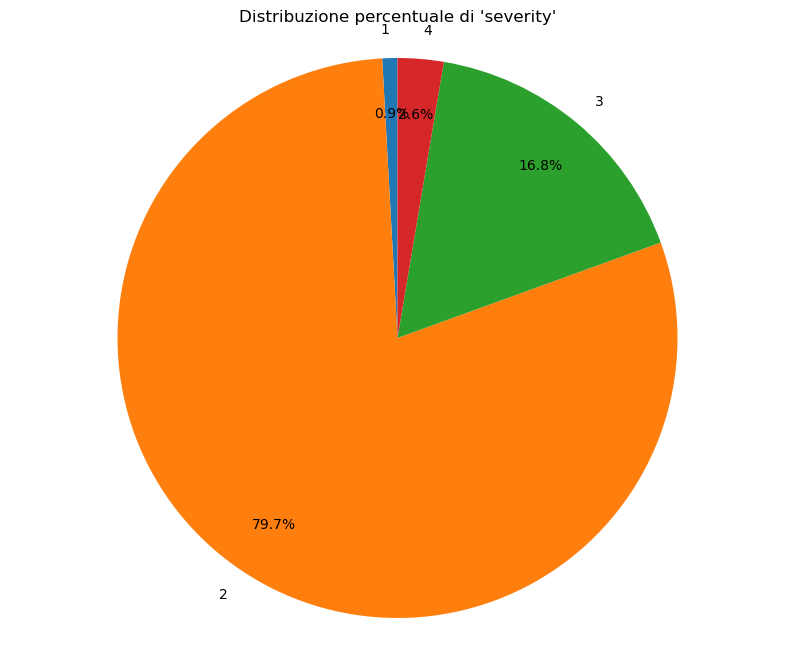

In [18]:
print(pdf["percent"])
# 4️⃣ Grafico a torta
plt.figure(figsize=(10, 8))
plt.pie(
    pdf["count"],
    labels=pdf["severity"],
    autopct=lambda p: f"{p:.1f}%",    # percentuali con 1 decimale
    startangle=90,
    pctdistance=0.8
)
plt.title("Distribuzione percentuale di 'severity'")
plt.axis("equal")  # mantiene il cerchio perfettamente rotondo
plt.show()

## Fill NaN with median

In [25]:
mean_temp = accidents.select(F.mean("Temperature(F)")).first()[0]

accidents = accidents.fillna({"Temperature(F)": mean_temp})

In [26]:
weather_numeric = ['Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)','Precipitation(in)']
    
for col in weather_numeric:
    mean = accidents.select(F.mean(col)).first()[0]
    accidents = accidents.fillna({col: mean})


## Drop unuseful columns

End_* columns are removed because aren't useful to predict the severity (can be defined only afterwards the incident)

In [ ]:
#accidents = accidents.drop('Astronomical_Twilight', 'Nautical_Twilight','Country')
accidents = accidents.drop('ID', "Source",'Description', 'Distance', 'End_Time', 'Distance(mi)', 'End_Lng', 'End_Lat', 'Duration')

## analyze categorical features

In [29]:
cat_names = [ 'Source', 'Street', 'City', 'County', 'State', 'Country', 
             'Timezone', 'Airport_Code', 'Wind_Direction',
              'Weather_Condition','Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']

print("Unique count of categorical features:")
for col in cat_names:
    count_unique = accidents.select(F.countDistinct(col)).first()[0]
    print(f"{col}: {count_unique}")

Unique count of categorical features:
Source: 3
Street: 336306
City: 13678
County: 1871
State: 49
Country: 1
Timezone: 4
Airport_Code: 2045
Wind_Direction: 24
Weather_Condition: 144
Sunrise_Sunset: 2
Civil_Twilight: 2
Nautical_Twilight: 2
Astronomical_Twilight: 2


## Drop categorical with 1 unique value

In [31]:
accidents = accidents.drop("Country","Turning_Loop")

## simplify wind direction 

In [35]:
print("Wind Direction: ")
accidents.select("Wind_Direction").distinct().show()


Wind Direction: 
+--------------+
|Wind_Direction|
+--------------+
|           SSE|
|            SW|
|            NW|
|          Calm|
|             E|
|           WSW|
|           ENE|
|            NE|
|         South|
|           NNW|
|             N|
|           SSW|
|             W|
|             S|
|            SE|
|          East|
|           WNW|
|           NNE|
|          West|
|           VAR|
+--------------+
only showing top 20 rows



In [37]:
wind_dir_mapping = {
    "North": 'N',
    'NNE': 'NE',
    'NE': 'NE',
    'ENE': 'E',
    'East': 'E',
    'ESE': 'SE',
    'SE': 'SE',
    'SSE': 'S',
    'South': 'S',
    'SSW': 'SW',
    'SW': 'SW',
    'WSW': 'W',
    'West': 'W',
    'WNW': 'NW',
    'NW': 'NW',
    'NNW': 'NW',
    "Calm":"CALM",
    "Variable":"VAR"
}
accidents = accidents.replace(wind_dir_mapping, subset=['Wind_Direction'])
print("Wind Direction after simplification: ")
accidents.select("Wind_Direction").distinct().show()

Wind Direction after simplification: 
+--------------+
|Wind_Direction|
+--------------+
|            SW|
|            NW|
|             E|
|            NE|
|             N|
|             W|
|             S|
|            SE|
|           VAR|
|          CALM|
|          NULL|
+--------------+



## simplify wehater_condition

In [41]:
accidents.select("Weather_Condition").distinct().show(150)

+--------------------+
|   Weather_Condition|
+--------------------+
|         Ice Pellets|
|         Shallow Fog|
|        Thunderstorm|
|        Volcanic Ash|
|   N/A Precipitation|
|Showers in the Vi...|
|              Cloudy|
| Light Freezing Rain|
|        Blowing Snow|
|  Heavy Rain / Windy|
|   Low Drifting Snow|
|Heavy Thunderstor...|
|     Widespread Dust|
|         Snow Grains|
|Light Rain with T...|
|             Squalls|
|    Scattered Clouds|
|       Heavy T-Storm|
|      Patches of Fog|
|        Rain Showers|
|Thunderstorms and...|
|             Drizzle|
|      Cloudy / Windy|
|             T-Storm|
|        Snow Showers|
|                 Fog|
|       Partly Cloudy|
|               Clear|
|  Light Freezing Fog|
|                Fair|
|       Heavy Drizzle|
|Heavy Thunderstor...|
|       Mostly Cloudy|
|        Funnel Cloud|
|               Smoke|
|   Light Ice Pellets|
|Light Freezing Dr...|
|          Light Haze|
|Heavy T-Storm / W...|
|          Heavy Rain|
|          

In [45]:
from pyspark.sql import functions as F

patterns = {
    "Clear": "Clear",
    "Cloud": "Cloud|Overcast",
    "Rain": "Rain|storm",
    "Heavy_Rain": "Heavy Rain|Rain Shower|Heavy T-Storm|Heavy Thunderstorms",
    "Snow": "Snow|Sleet|Ice",
    "Heavy_Snow": "Heavy Snow|Heavy Sleet|Heavy Ice Pellets|Snow Showers|Squalls",
    "Fog": "Fog"
}

# inizia con colonna vuota
expr = F.lit(None)

for category, pattern in patterns.items():
    expr = F.when(
        F.col("Weather_Condition").rlike(f"(?i){pattern}"), 
        category
    ).otherwise(expr)
    
accidents = accidents.withColumn("Weather_Condition", expr)
accidents.select("Weather_Condition").distinct().show(150)

+-----------------+
|Weather_Condition|
+-----------------+
|       Heavy_Rain|
|              Fog|
|            Clear|
|       Heavy_Snow|
|             Rain|
|             Snow|
|            Cloud|
|             NULL|
+-----------------+



## Conversione timestamps

In [46]:
accidents = accidents.withColumn(
    "Start_Time_parsed_str",
    F.substring(F.col("Start_Time"), 1, 19)
)

# Converte in timestamp usando il formato specifico
accidents = accidents.withColumn(
    "Start_Time_parsed",
    F.to_timestamp("Start_Time_parsed_str", "yyyy-MM-dd HH:mm:ss")
)

accidents.select("Start_Time_parsed").show(10, truncate=False)

+-------------------+
|Start_Time_parsed  |
+-------------------+
|2016-02-08 05:46:00|
|2016-02-08 06:07:59|
|2016-02-08 06:49:27|
|2016-02-08 07:23:34|
|2016-02-08 07:39:07|
|2016-02-08 07:44:26|
|2016-02-08 07:59:35|
|2016-02-08 07:59:58|
|2016-02-08 08:00:40|
|2016-02-08 08:10:04|
+-------------------+
only showing top 10 rows



### Gestione date con nuovi dati estrapolati

In [50]:
# -----------------------------
# 1) Date features
# -----------------------------
accidents = accidents.withColumn("Hour",  F.hour("Start_Time_parsed") + 1)
accidents = accidents.withColumn("Day",   F.dayofweek("Start_Time_parsed"))  # Spark: 1 = Sunday
accidents = accidents.withColumn("Month", F.month("Start_Time_parsed"))
accidents = accidents.withColumn("Year",  F.year("Start_Time_parsed"))

# -----------------------------
# 4) Part_of_Day (cut)
# -----------------------------
accidents = accidents.withColumn(
    "Part_of_Day",
    F.when(F.col("Hour").between(1, 6),  "Night")
     .when(F.col("Hour").between(7, 12), "Morning")
     .when(F.col("Hour").between(13, 18),"Afternoon")
     .otherwise("Evening")
)

# -----------------------------
# 5) Sunrise_Sunset (Day/Night)
# -----------------------------
accidents = accidents.withColumn(
    "Sunrise_Sunset",
    F.when(F.col("Hour").between(1, 16), "Day")
     .otherwise("Night")
)

# -----------------------------
# 6) Show results
# -----------------------------
accidents.select("Hour", "Day", "Month", "Year", "Part_of_Day", "Sunrise_Sunset").show(10)


+----+---+-----+----+-----------+--------------+
|Hour|Day|Month|Year|Part_of_Day|Sunrise_Sunset|
+----+---+-----+----+-----------+--------------+
|   6|  2|    2|2016|      Night|           Day|
|   7|  2|    2|2016|    Morning|           Day|
|   7|  2|    2|2016|    Morning|           Day|
|   8|  2|    2|2016|    Morning|           Day|
|   8|  2|    2|2016|    Morning|           Day|
|   8|  2|    2|2016|    Morning|           Day|
|   8|  2|    2|2016|    Morning|           Day|
|   8|  2|    2|2016|    Morning|           Day|
|   9|  2|    2|2016|    Morning|           Day|
|   9|  2|    2|2016|    Morning|           Day|
+----+---+-----+----+-----------+--------------+
only showing top 10 rows



In [51]:
accidents = accidents.drop("Start_Time_parsed")

## Analisys of NaN

In [ ]:

# Numero totale di righe
total_rows = accidents.count()

# Calcolo missing per ogni colonna
missing_df = accidents.select([
    (F.count(F.when(F.col(c).isNull(), 1)) / total_rows * 100)
    .alias(c)
    for c in accidents.columns
])

# Converti in pandas per lo stesso stile tabellare
missing_pd = missing_df.toPandas().T.reset_index()

# Rename colonne per essere identici al tuo output Pandas
missing_pd.columns = ["Feature", "Missing_Percent(%)"]

# Filtra solo le colonne con missing > 0%
missing_pd = missing_pd[missing_pd["Missing_Percent(%)"] > 0]

missing_pd.


,Feature,Missing_Percent(%)
4,Street,0.140637
5,City,0.003274
8,Zipcode,0.024779
9,Timezone,0.101030
10,Airport_Code,0.292881
11,Weather_Timestamp,1.555666
17,Wind_Direction,2.267043
20,Weather_Condition,38.088237
34,Civil_Twilight,0.300787
35,Nautical_Twilight,0.300787


## Altro

In [11]:
accidents = accidents.withColumn(
    "Weather_Condition",
    F.coalesce(F.col("Weather_Condition"), F.lit("Unknown"))
)

accidents = accidents.withColumn(
    "Wind_Direction",
    F.coalesce(F.col("Wind_Direction"), F.lit("Unknown"))
)

In [13]:
accidents = accidents.withColumn(
    "Weather_Timestamp",
    F.coalesce(F.col("Weather_Timestamp"), F.col("Start_Time"))
)

In [14]:
accidents = accidents.withColumn(
    "Street",
    F.coalesce(F.col("Street"), F.lit("Unknown"))
)

accidents = accidents.withColumn(
    "Zipcode",
    F.coalesce(F.col("Zipcode"), F.lit("Unknown"))
)

In [19]:
accidents = accidents.withColumn(
    "City",
    F.coalesce(F.col("City"), F.lit("Unknown"))
)

In [26]:
accidents = accidents.withColumn(
    "End_Time_parsed_str",
    F.substring(F.col("End_Time"), 1, 19)
)

# Converte in timestamp usando il formato specifico
accidents = accidents.withColumn(
    "End_Time_parsed",
    F.to_timestamp("End_Time_parsed_str", "yyyy-MM-dd HH:mm:ss")
)

In [27]:
accidents = accidents.withColumn(
    "Weather_Timestamp_parsed_str",
    F.substring(F.col("End_Time"), 1, 19)
)

# Converte in timestamp usando il formato specifico
accidents = accidents.withColumn(
    "Weather_Timestamp_parsed",
    F.to_timestamp("Weather_Timestamp_parsed_str", "yyyy-MM-dd HH:mm:ss")
)

+----+---+-----+----+--------+-----------+--------------+
|Hour|Day|Month|Year|Duration|Part_of_Day|Sunrise_Sunset|
+----+---+-----+----+--------+-----------+--------------+
|   6|  2|    2|2016|   314.0|      Night|           Day|
|   7|  2|    2|2016|    30.0|    Morning|           Day|
|   7|  2|    2|2016|    30.0|    Morning|           Day|
|   8|  2|    2|2016|    30.0|    Morning|           Day|
|   8|  2|    2|2016|    30.0|    Morning|           Day|
|   8|  2|    2|2016|    30.0|    Morning|           Day|
|   8|  2|    2|2016|    30.0|    Morning|           Day|
|   8|  2|    2|2016|    30.0|    Morning|           Day|
|   9|  2|    2|2016|    30.0|    Morning|           Day|
|   9|  2|    2|2016|    30.0|    Morning|           Day|
+----+---+-----+----+--------+-----------+--------------+
only showing top 10 rows



In [29]:
null_counts = accidents.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c)
    for c in accidents.columns
])

null_counts.show()

+---+------+--------+----------+--------+---------+---------+-------+-------+------------+------+----+-----+-----------------+--------------+-------------+-----------+------------+--------------+---------------+-----------------+-----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+--------------+---------------------+-----------------+-------------------+---------------+----------------------------+------------------------+----+---+-----+----+------------+--------+-----------+
| ID|Source|Severity|Start_Time|End_Time|Start_Lat|Start_Lng|End_Lat|End_Lng|Distance(mi)|Street|City|State|Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Sunrise_Sunset|Start_Time_parsed_str|Start_Time_parsed|End

In [30]:
train_split, test_split = accidents.randomSplit([0.7, 0.3], seed=42)

In [31]:
train_split.count()

5410679